## Load Model

In [ ]:
## Load Model
import pandas as pd
import numpy as np
import sys
import os
import tensorflow as tf
from tensorflow.keras.models import load_model

sys.path.append(os.path.abspath(".."))

from src.preprocessing import preprocess_data, create_sequences

# Load the trained model
model = load_model('../models/lstm_energy_prediction_model.h5', compile=False)

# Preprocess the latest data
X_train, X_test, y_train, y_test, x_scaler, y_scaler = preprocess_data("../data/lora_data_5_6_25.csv")

# If preprocess_data returns sequences already:
print("X_train shape:", X_train.shape)  # Should be (n_seq, seq_len, n_feat)
initial_sequence = X_train[-1:]  # Shape is (1, seq_len, n_feat)

# Predict the next 24 hours of energy consumption
def predict_future(model, initial_sequence, y_scaler, num_hours=24):
    predictions = []
    current_sequence = initial_sequence.copy()

    for _ in range(num_hours):
        # Predict the next hour
        next_pred = model.predict(current_sequence, verbose=0)
        predictions.append(next_pred[0, 0])

        # Update the sequence for the next prediction
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1, :] = next_pred

    # Inverse transform the predictions
    predictions = y_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions.flatten()

# Make predictions
try:
    future_predictions = predict_future(model, initial_sequence, y_scaler)
    print(f"Predictions for the next 24 hours: {future_predictions}")
except Exception as e:
    print(f"An error occurred: {str(e)}")
    print(f"Model input shape: {model.input_shape}")
    print(f"Initial sequence shape: {initial_sequence.shape}")

X_train shape: (538, 24, 24)
Predictions for the next 24 hours: [-3.4517772e-04 -2.5101696e-04 -1.0272243e-04  5.2011750e-05
  1.8086471e-04  2.8646126e-04  3.6811223e-04  4.3127406e-04
  4.7588118e-04  5.0814345e-04  5.3719501e-04  5.3410709e-04
  5.2666530e-04  5.1610329e-04  5.0458458e-04  4.9475988e-04
  4.8539936e-04  4.7853729e-04  4.7124273e-04  4.6493011e-04
  4.6237791e-04  4.6571219e-04  4.7534204e-04  4.9294002e-04]


[0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.01075 0.00675 0.      0.00225 0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.014   0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.0005  0.02175 0.00525 0.      0.00525 0.0055  0.018   0.0055
 0.0146  0.0046  0.0098  0.005   0.0218  0.0044  0.0104  0.0046  0.0142
 0.0152  0.009   0.0048  0.0054  0.0046  0.0088  0.0054  0.      0.005
 0.0044  0.0046  0.0102  0.0044  0.009   0.0058  0.0046  0.0136  0.015
 0.0122  0.0028  0.0002  0.0164  0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.00375 0.00175 0.      0.     ]


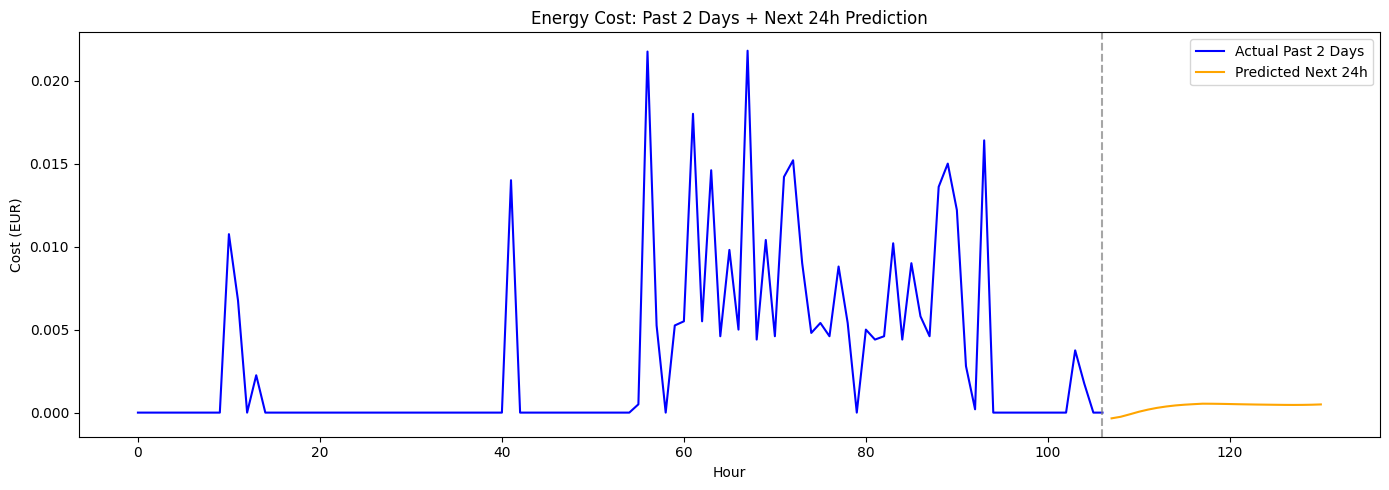

In [8]:
import matplotlib.pyplot as plt

# Get last 48 hours of actual (real) costs from test set
real_past = y_scaler.inverse_transform(y_test[-(X_train.shape[0]):]).flatten()
# Predicted next 24 hours (already inverse transformed in your code)
predicted_future = future_predictions  # shape (24,)

print(real_past)
past_timesteps = list(range(len(real_past)))
future_timesteps = list(range(len(real_past), len(real_past) + len(predicted_future)))

plt.figure(figsize=(14, 5))
plt.plot(past_timesteps, real_past, label="Actual Past 2 Days", color="blue")
plt.plot(future_timesteps, predicted_future, label="Predicted Next 24h", color="orange")
plt.axvline(x=past_timesteps[-1], color="gray", linestyle="--", alpha=0.7)
plt.xlabel("Hour")
plt.ylabel("Cost (EUR)")
plt.title("Energy Cost: Past 2 Days + Next 24h Prediction")
plt.legend()
plt.tight_layout()
plt.show()
